In [1]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import math

In [2]:
nx = 64 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
number_of_grain = 7 # total number of grains: N
dx, dy = 0.5e-6, 0.5e-6 # spacing of computational grids [m]
dt = 0.05 # time increment [s]
nsteps = 500# total number of time-steps
pi = np.pi 
sigma = 1.0 # grain boundary energy [J/m2]
delta = 6.0 * dx # thickness of diffuse interface
eee = 3.0e+6 # magnitude of driving force

In [3]:
aaa = 2.0 / pi * np.sqrt(2.0*delta*sigma) # gradient energy coefficient
www = 4.0 * sigma/delta # height of double-obstacle potential
pmobi = pi*pi/(8.*delta)*3.0e-13 # mobility of phase-field 

In [4]:
wij = np.zeros((number_of_grain,number_of_grain)) # array for the height of double-obstacle potential
aij = np.zeros((number_of_grain,number_of_grain)) # array for the gradient energy coefficient
mij = np.zeros((number_of_grain,number_of_grain)) # array for the mobility of phase-field 
eij = np.zeros((number_of_grain,number_of_grain)) # arrays for saving the magnitude of driving foce of grain boundary migration

In [5]:
phi = np.zeros((number_of_grain,nx,ny)) 
phi_new = np.zeros((number_of_grain,nx,ny)) 
mf = np.zeros((15,nx,ny),dtype = int) 
nf = np.zeros((nx,ny),dtype = int) 

In [6]:
gb = np.zeros((nx,ny)) 
gi = np.zeros((nx,ny),dtype = int) 

In [7]:
for i in range(0,number_of_grain):
    for j in range(0,number_of_grain):
        wij[i,j] = www
        aij[i,j] = aaa
        mij[i,j] = pmobi
        eij[i,j] = 0.0
        if i == j:
            wij[i,j] = 0.0
            aij[i,j] = 0.0
            mij[i,j] = 0.0
        if i == 0 or j == 0:
            eij[i,j] = eee
        if i < j:
            eij[i,j] = -eij[i,j]

In [8]:
def update_nfmf(phi,mf,nf):
    for m in range(ny):
        for l in range(nx):
            l_p = l + 1
            l_m = l - 1
            m_p = m + 1
            m_m = m - 1
            if l_p > nx-1:
                l_p = l_p - nx
            if l_m < 0:
                l_m = l_m + nx
            if m_p > ny-1:
                m_p = m_p - ny
            if m_m < 0:
                m_m = m_m + ny
            n = 0
            for i in range(number_of_grain):
                if phi[i,l,m] > 0.0 or (phi[i,l,m] == 0.0 and phi[i,l_p,m] > 0.0 or phi[i,l_m,m] > 0.0 or phi[i,l,m_p] > 0.0 or phi[i,l,m_m] > 0.0):
                    n += 1
                    mf[n-1,l,m] = i
            nf[l,m] = n

In [9]:
def update_phasefield(phi,phi_new,mf,nf,eij):
    for m in range(ny):
        for l in range(nx):
            l_p = l + 1
            l_m = l - 1
            m_p = m + 1
            m_m = m - 1
            if l_p > nx-1: 
                l_p = l_p - nx
            if l_m < 0:
                l_m = l_m + nx
            if m_p > ny-1:
                m_p = m_p - ny
            if m_m < 0:
                m_m = m_m + ny
            for n1 in range(nf[l,m]):
                i = mf[n1,l,m]
                dpi = 0.0
                for n2 in range(nf[l,m]):
                    j = mf[n2,l,m]
                    ppp = 0.0
                    for n3 in range(nf[l,m]):
                        k = mf[n3,l,m]
                        ppp += (wij[i,k]-wij[j,k])*phi[k,l,m]+0.5*(aij[i,k]**2 - aij[j,k]**2)*(phi[k,l_p,m]+phi[k,l_m,m]+phi[k,l,m_p]+phi[k,l,m_m]-4.0*phi[k,l,m])/dx/dx
                        phii_phij = phi[i,l,m]*phi[j,l,m]
                        dpi = dpi - 2.0 * mij[i,j] / float(nf[l,m]) * (ppp - 8./pi*np.sqrt(phii_phij)*eij[i,j])
                phi_new[i,l,m] = phi[i,l,m] + dpi *dt

    phi_new = np.where(phi_new <= 0.0,0.0,phi_new)
    phi_new = np.where(phi_new >= 1.0,1.0,phi_new)
    
    for m in range(ny):
        for l in range(nx):
            a = np.sum(phi_new[:,l,m])
            phi[:,l,m] = phi_new[:,l,m] / a

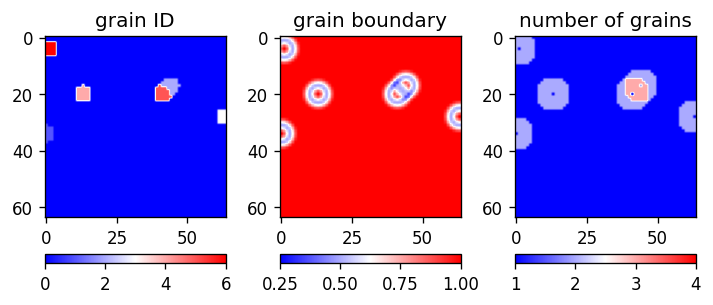

In [10]:
phi = np.zeros((number_of_grain,nx,ny))
phi_new = np.zeros((number_of_grain,nx,ny))
mf = np.zeros((15,nx,ny),dtype = int)
nf = np.zeros((nx,ny),dtype = int)

phi[0,:,:] = 1.0
nf[:,:] = 1
r_nuclei = 3.*dx # radius of the initial grains

for i in range(1,number_of_grain):
    x_nuclei = int(rand()*nx)
    y_nuclei = int(rand()*ny)
    for m in range(ny):
        for l in range(nx):
            if l > nx-1: 
                l = l - nx
            if l < 0:
                l = l + nx
            if m > ny-1:
                m = m - ny
            if m < 0:
                m = m + ny
            r = np.sqrt( (l *dx-x_nuclei*dx)**2 +(m*dy-y_nuclei*dy)**2 ) - r_nuclei
            tmp = np.sqrt(2.*www)/aaa*r
            phi_tmp = 0.5*(1.-np.sin(tmp))
            if tmp >= pi/2.:
                phi_tmp=0.
            if tmp <= -pi/2.:
                phi_tmp=1.
            if 0. < phi_tmp < 1.: 
                nf_tmp = nf[l,m]+1
                nf[l,m] = nf_tmp
                mf[nf_tmp-1,l,m] = i
                phi[i,l,m] = phi_tmp            
                phi[0,l,m] = phi[0,l,m]-phi[i,l,m]
                if phi[0,l,m] < 0.:
                    phi[0,l,m] = 0.
            if phi_tmp >= 1.: 
                nf_tmp = 1
                nf[l,m] = nf_tmp
                mf[0,l,m] = i
                phi[i,l,m] = phi_tmp            
                phi[0,l,m] = 0.

for m in range(0,ny):
    for l in range(0,nx):
        a = np.sum(phi[:,l,m])
        phi[:,l,m] = phi[:,l,m] / a
        gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])
        phi_max = 0.
        for n in range(nf[l,m]):
            i = mf[n,l,m]
            if phi[i,l,m] > phi_max:
                gi[l,m] = i
                phi_max = phi[i,l,m]

fig = plt.figure(figsize=(7,4))
fig.set_dpi(120)
plt.subplots_adjust(wspace=0.3)
        
plt.subplot(1,3, 1)
plt.imshow(gi, cmap='bwr', vmin=0, vmax=number_of_grain-1)
plt.title('grain ID')
plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
plt.subplot(1,3, 2)
plt.imshow(gb, cmap="bwr",  vmin=0.25, vmax=1.)
plt.title('grain boundary')
plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
plt.subplot(1,3, 3)
plt.imshow(nf, cmap='bwr', vmin=1, vmax=4)
plt.title('number of grains')
plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
plt.show()

nstep =  50


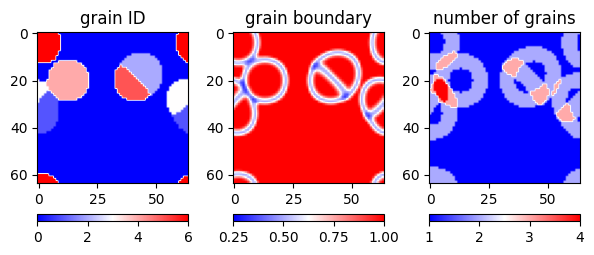

nstep =  100


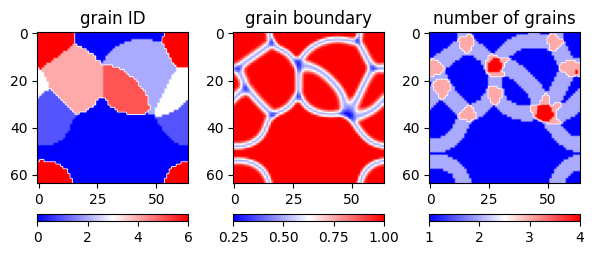

nstep =  150


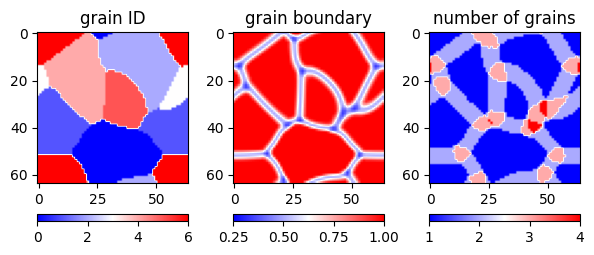

nstep =  200


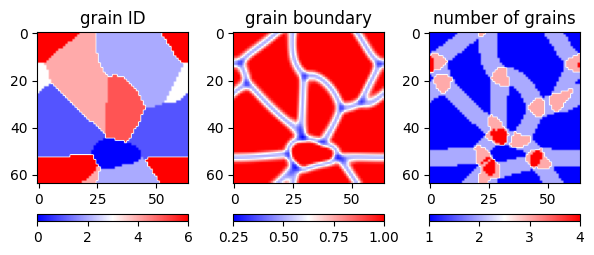

nstep =  250


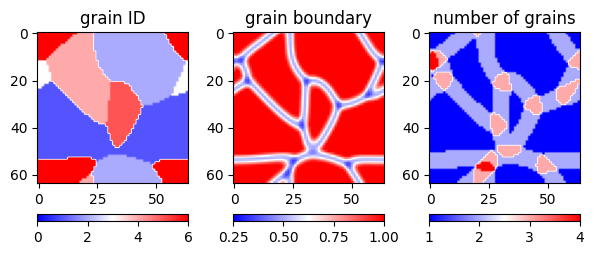

nstep =  300


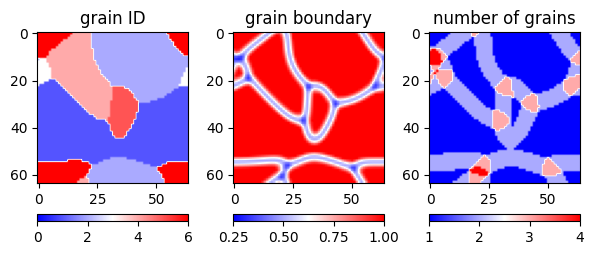

nstep =  350


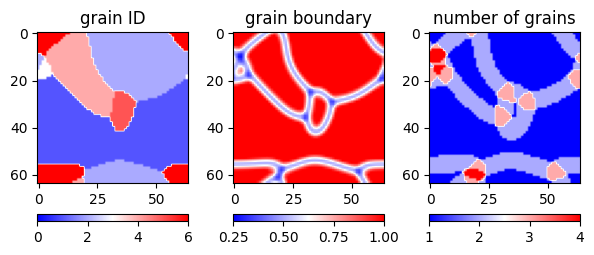

nstep =  400


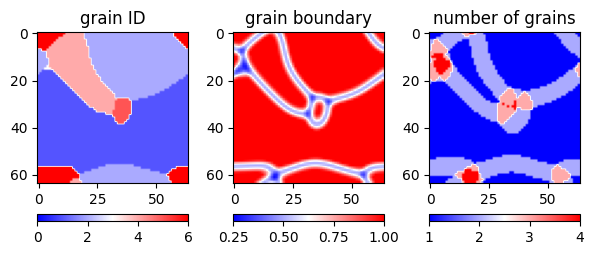

nstep =  450


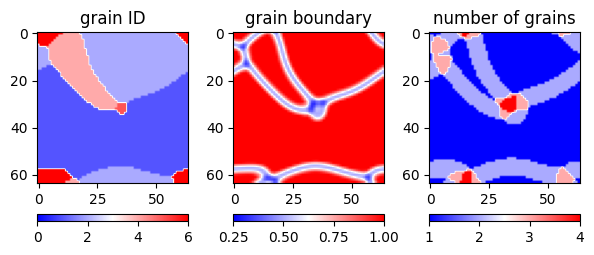

nstep =  500


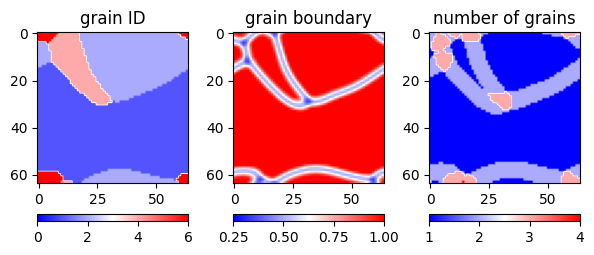

In [11]:
for nstep in range(1,nsteps+1):
    update_nfmf(phi,mf,nf)
    update_phasefield(phi,phi_new,mf,nf,eij)
    
    if nstep % 50 == 0:
        print('nstep = ', nstep)
        for m in range(0,ny):
            for l in range(0,nx):
                gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])
                phi_max = 0.
                for n in range(nf[l,m]):
                    i = mf[n,l,m]
                    if phi[i,l,m] > phi_max:
                        gi[l,m] = i
                        phi_max = phi[i,l,m]

        fig = plt.figure(figsize=(7,4))
        fig.set_dpi(100)
        plt.subplots_adjust(wspace=0.3)
        
        plt.subplot(1,3, 1)        
        plt.imshow(gi, cmap='bwr', vmin=0, vmax=number_of_grain-1)
        plt.title('grain ID')
        plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
        plt.subplot(1,3, 2)        
        plt.imshow(gb, cmap='bwr', vmin=0.25, vmax=1.)
        plt.title('grain boundary')
        plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')
        plt.subplot(1,3, 3)        
        plt.imshow(nf, cmap='bwr', vmin=1, vmax=4)
        plt.title('number of grains')
        plt.colorbar(aspect=20, pad=0.1, orientation='horizontal')      
        plt.show()